In [1]:
__author__ = 'Stephanie Juneau <stephanie.juneau@noirlab.edu>, Robert Nikutta <robert.nikutta@noirlab.edu>, Astro Data Lab Team <datalab@noirlab.edu>'
__version__ = '20240515' # yyyymmdd
__datasets__ = ['des_dr1']
__keywords__ = ['galaxies', 'object classification', 'plot:color-color', 'stars']

# Star/Galaxy/QSO Classification in the Dark Energy Survey (DES)
by Stéphanie Juneau, Knut Olsen, Robert Nikutta, and the Astro Data Lab Team

### Table of contents
* [Goals & summary](#goals)
* [Disclaimer & attribution](#attribution)
* [Introduction](#introduction)
* [Imports & setup](#import)
* [Query DES photometry catalog](#query)
* [Plot results](#plots)
* [Appendix: comparison with DES Team classification](#compare)
* [Appendix: <tt>class_star</tt> comparison](#classstar)
* [References](#resources)

<a class="anchor" id="goals"></a>
# Goals
* Investigate optical and infrared colors from DES catalogs
* Classify objects likely to be stars or galaxies

# Summary
In this notebook, we investigate the optical colors of astronomical sources detected in the [Dark Energy Survey (DES)](https://www.darkenergysurvey.org/), an imaging survey conducted with the Dark Energy Camera (DECam) on the 4-meter Blanco telescope. The first data release, DR1, comprises ~400 millions stars, galaxies and quasars (or QSOs: Quasi-Stellar Objects). 

Astro Data Lab products and services used here:
<ul>
<li>the DES DR1 database</li>
<li>Jupyter Notebook Server</li>
<li>Query Manager</li>
</ul>

Below, we query the database, compute colors, plot a few color combinations, and take into account the source shapes as defined from the spread of the light profiles and a pre-computed star-galaxy classifier, in order to differentiate between object classes. In this notebook, we focus on star-galaxy separation, and do not yet attempt to classify QSOs.

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445
* If you use the DES data, please acknowledge: DES Collaboration "The Dark Energy Survey Data Release 1" ApJS 239, 18, 2018, https://iopscience.iop.org/article/10.3847/1538-4365
* Data Lab disclaimer: https://datalab.noirlab.edu/disclaimers.php

<a class="anchor" id="introduction"></a>
# Introduction

An imaging survey includes a zoo of different astronomical objects. There are foreground stars from our own Milky Way galaxy, and background galaxies at various distances, including QSOs with actively accreting supermassive black holes. In this notebook, we aim to distinguish between object classes using combinations of colors and shape parameters. 

There are several possible science applications. For example, one could select stars in order to study stellar populations from the Milky Way or search for specific classes of stars (Red Giants, etc.). Alternatively, one can select galaxies to address questions in galaxy evolution or to probe their spatial organization in large-scale structures. Below, we explore possible classifications, compare the results from different bands/filters, and refer to example classifications suggested by the DES team.

## Magnitudes and colors

Magnitudes are obtained through a set of filters similar to the *u,g,r,i,z* set used for SDSS. In this work, we use 
*g,r,z* from the Dark Energy Camera (DECam)

Colors are defined as a difference between magnitudes in two bands. A "redder" color means that the object is comparatively brighter in the redder (i.e., longer wavelength) band. Conversely, a "bluer" color means that the object is comparatively brighter in the bluer (i.e., shorter wavelength) band. 

We will use the following colors: 
* *g-r*
* *r-z*

## Object shapes/types

The object shape (2D light profile) can be defined with a size and ellipticity. In this notebook, we are interested in using extension of the images to distinguish between stars (point sources), galaxies (resolved, if not too distant), and QSOs (which may have both point-like and resolved components). 

* `kron_radius`: Kron radius in pixels 
* `spread_model_X`: star-galaxy classifier comparing extended model to PSF model. Value is given for each band X = *g, r, i, z, y*
* `class_star_X`: value ranging from 0.0 (not point-like) to 1.0 (point-like), for each band X = *g, r, i, z, y* 

The value of `spread_model` is near zero for a point source (star or QSO), positive for an extended source (galaxy), negative for an artifact smaller than the PSF (e.g., bad pixel or cosmic ray). More information about the `spread_model` can be found in [Desai et al (2012)](https://ui.adsabs.harvard.edu/abs/2012ApJ...757...83D), and [Soumagnac et al (2015)](https://ui.adsabs.harvard.edu/abs/2015MNRAS.450..666S).

<a class="anchor" id="import"></a>
# Imports and setup

In [2]:
# 3rd party
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Data Lab
from dl import queryClient as qc, storeClient as sc
from dl.helpers.utils import convert

<a class="anchor" id="query"></a>
# Query DES photometry catalog

The photometry is derived from SourceExtractor modeling of sources, and the database includes model photometry, type (shape), as well as aperture photometry in various aperture sizes. In this work, we will use SourceExtractor adaptive aperture magnitudes (MAG_AUTO).

The database is called **des_dr1** and includes several tables. We will use the **main** table. The column names and descriptions can be found from the [Data Lab Query Interface](https://datalab.noirlab.edu/query.php) or using the Table Access Protocol (TAP) service with, e.g., TOPCAT. In both cases, we are interested in **des_dr1.main**.

In [3]:
# Write query statement (sql) as a string
# NOTE: triple quotes allow us to break the string on multiple lines
query = """
        SELECT mag_auto_g as gmag, mag_auto_r as rmag, mag_auto_z as zmag, 
               mag_auto_i as imag, mag_auto_y as ymag, 
               kron_radius, spread_model_g, class_star_g, spread_model_r, class_star_r, 
               spread_model_z, class_star_z, 
               snr_g, snr_r, snr_z, ra, dec
        FROM des_dr1.main 
        WHERE (fluxerr_auto_g>0 and fluxerr_auto_r>0 and fluxerr_auto_z>0)
        LIMIT 300000"""

# mag_auto_g,r,i,z,y = AB magnitudes in DECam g,r,i,z,y bands
# kron_radius        = Kron radius from SExtractor (pixels)
# spread_model_g,r,z = star/galaxy classifier quantifying light profile relative to PSF
# class_star_g,r,z   = star/extended source classifier (from 0 to 1)
# snr_g,r,z          = computed signal-to-noise ratios (S/N) in g,r,z bands
# ra,dec             = celestial coordinates
#
# WHERE: requirement that error>0 (to avoid dividing by zero) in g,r,z bands
# LIMIT: returns 300,000 rows that satisfy the query

print(query)


        SELECT mag_auto_g as gmag, mag_auto_r as rmag, mag_auto_z as zmag, 
               mag_auto_i as imag, mag_auto_y as ymag, 
               kron_radius, spread_model_g, class_star_g, spread_model_r, class_star_r, 
               spread_model_z, class_star_z, 
               snr_g, snr_r, snr_z, ra, dec
        FROM des_dr1.main 
        WHERE (fluxerr_auto_g>0 and fluxerr_auto_r>0 and fluxerr_auto_z>0)
        LIMIT 300000


In [4]:
# Execute the query synchronously, if short (e.g., LIMIT<=300,000)
# We then convert the returned result, a CSV-formatted string, to a Pandas data frame,
# making sure that any potential 'Infinity' values are converted to NaN.
res = qc.query(sql=query)
df = convert(res,'pandas',na_values=('Infinity','-Infinity'))

In [5]:
# Print a few rows from the result data frame
print(df[:5])
len(df)

        gmag       rmag       zmag       imag       ymag  kron_radius  \
0  99.000000  23.723530  21.844639  22.748678  21.612795     5.636725   
1  24.590650  24.238567  23.377520  23.463213  22.426397     7.349276   
2  22.358858  20.941229  19.088203  19.648966  18.954773     3.500000   
3  22.800650  21.734190  20.943510  21.251347  21.216537     3.960677   
4  24.076948  24.123098  23.687569  23.560404  24.456005     4.853493   

   spread_model_g  class_star_g  spread_model_r  class_star_r  spread_model_z  \
0        1.000000      0.387410        0.007153      0.001145        0.006896   
1        0.002813      0.396117        0.015848      0.076924       -0.006221   
2       -0.001526      0.487896       -0.000769      0.874804       -0.000278   
3        0.007506      0.012388        0.015157      0.022475        0.018248   
4        0.006381      0.511646       -0.001337      0.638196       -0.006208   

   class_star_z      snr_g      snr_r       snr_z          ra        dec  

300000

<a class="anchor" id="plots"></a>
# Plot results

## Optical color-color diagram

In [6]:
# Select range of interest
thres = 5.   #threshold value for S/N (here, making it more stringent than query)
keep = (df['snr_g']>thres)&(df['snr_r']>thres)&(df['snr_z']>thres)

# Colors
g_r   = df['gmag'][keep] - df['rmag'][keep]
r_z   = df['rmag'][keep] - df['zmag'][keep]

r_i   = df['rmag'][keep] - df['imag'][keep]
i_z   = df['imag'][keep] - df['zmag'][keep]
z_y   = df['zmag'][keep] - df['ymag'][keep]

print(f'Count: {len(g_r)}')

Count: 106023


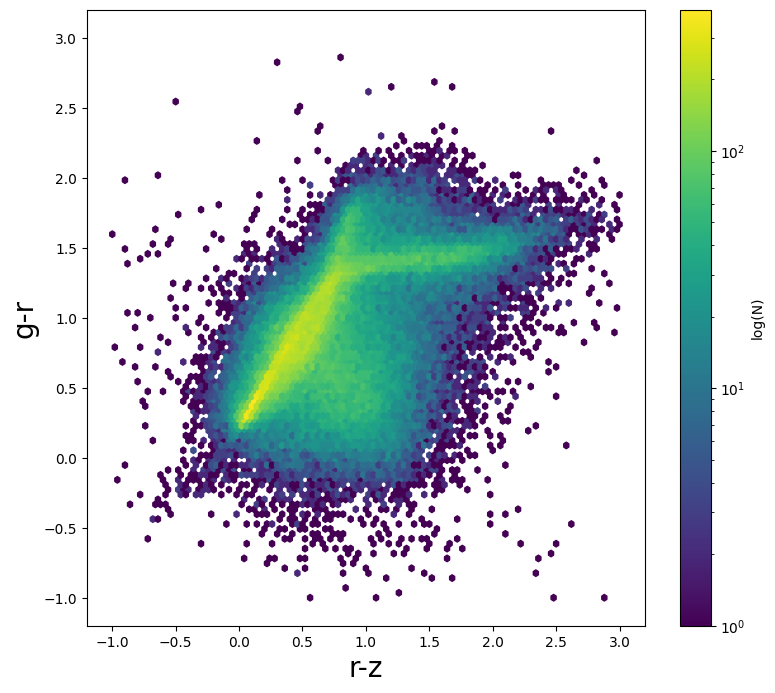

In [7]:
col0 = r_z   #r-z color
col1 = g_r   #g-r color

# 2D-histogram of objects
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.hexbin(col0, col1, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-1., 3, -1., 3))
ax1.set_xlabel('r-z',fontsize=20)
ax1.set_ylabel('g-r',fontsize=20)

#color bar
cb = plt.colorbar(im1,label='log(N)')

In the figure above, we can see structure in the number density map such as two curved branches that cross or overlap, along with a more diffuse clump or cloud of objects. We will revisit this color-color plot below after classifying objects into stars and galaxies. This will help to isolate the two branches.

## Morphological parameters

In this section, we make series of plots combining morphological parameters such as `spread_model`, `class_star`, and `kron_radius` with magnitudes (in each of *g*, *r* & *z* bands). The goals are to determine which quantities help to classify objects into stars and galaxies, and to compare the consistency and differences between results obtained with the different bands. 

In [8]:
def plot_morph(df,band='g'):
    """
    Plots in two columns x two rows
    """   
    fig = plt.figure(figsize=(8*2,8*2))
    ax = fig.add_subplot(2,2,1)
    ax.hexbin(df[band+'mag'],df['spread_model_'+band],gridsize=200,bins='log',mincnt=1,extent=(12,26,-0.05,0.05))
    ax.set_xlabel(band,fontsize=20)
    ax.set_ylabel('spread_model_'+band,fontsize=20)
    ax.tick_params(labelsize=10)

    ax2 = fig.add_subplot(2,2,2)
    ax2.hexbin(df['kron_radius'],df['class_star_'+band],gridsize=200,bins='log',mincnt=1,extent=(0,10,0,1))
    ax2.set_xlabel('Kron radius',fontsize=20)
    ax2.set_ylabel('class_star_'+band,fontsize=20)
    ax2.tick_params(labelsize=10)

    ax3 = fig.add_subplot(2,2,3)
    ax3.hexbin(df[band+'mag'],df['class_star_'+band],gridsize=200,bins='log',mincnt=1,extent=(12,26,0,1))
    ax3.set_xlabel(band,fontsize=20)
    ax3.set_ylabel('class_star_'+band,fontsize=20)
    ax3.tick_params(labelsize=10)

    ax4 = fig.add_subplot(2,2,4)
    ax4.hexbin(df['spread_model_'+band],df['class_star_'+band],gridsize=200,bins='log',mincnt=1,extent=(-0.025,0.025,0,1))
    ax4.set_xlabel('spread_model_'+band,fontsize=20)
    ax4.set_ylabel('class_star_'+band,fontsize=20)
    ax4.tick_params(labelsize=10)

### *g* band

First, we plot the results only for the *g* band, requiring a signal-to-noise > 5 in the *g* filter.

Number of objects with S/N>5 & valid spread_model in g band:  150969


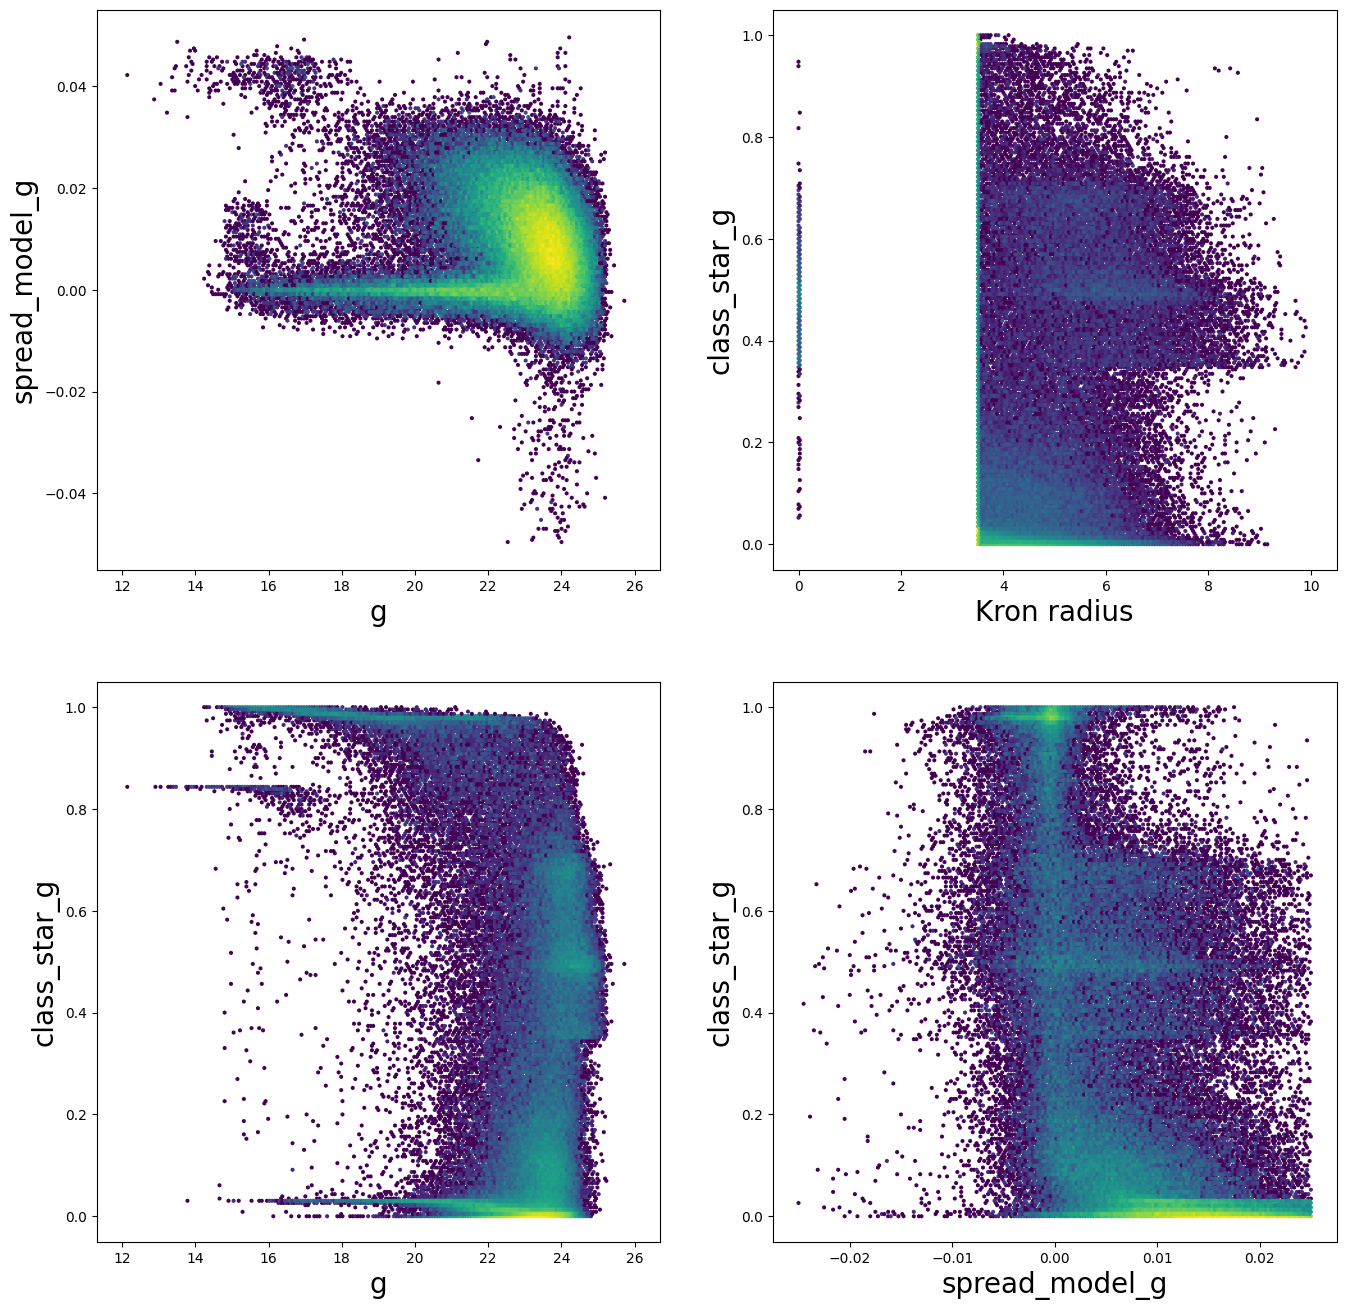

In [9]:
# invalid mags are set to 99 -> mag_auto_X < 90
# spread_model_X is valid at abs(spread_model)<1
# require S/N>5 in the g band
df_in=df[(df['gmag']<90) & (df['imag']<90) & (df['spread_model_g']>(-1)) & \
      (df['rmag']<90) & (df['zmag']<90) & (df['spread_model_g']<1) & \
      ((df['snr_g'])>5)]

print('Number of objects with S/N>5 & valid spread_model in g band: ',len(df_in))

plot_morph(df_in)

As a reminder, `spread_model` should be nearly 0 for point-sources, positive for extended sources, and negative for data artifacts smaller than the PSF. The top left panel clearly shows stars along an horizontal sequence around 0 spread. However, we can see that the other group of points (presummably galaxies) join and overlap with the stars at faint magnitudes starting around *g*=23. 

Similarly, `class_star` values range from 0.0 (not point-like) to 1.0 (point-like). One would thus expect that a confident classification would be nearly 0 for stars, and nearly 1 for resolved galaxies. Indeed, the two panels of the bottom row show two clear branches at low and high values. However, there are also a few ridge-like structures along `class_star` with values between 0.3-0.7. We suspect that these correspond to lower quality measurements. We will see below that these ridges are less prominent in redder bands (in *r*, and particularly in *z*), and that they also vanish when using *g* band measurements of objects with good detections in all 3 bands.

### *r* band

Second, we plot the results only for the *r* band, requiring a signal-to-noise > 5 in the *r* filter.

Number of objects with S/N>5 & valid spread_model in r band:  215545


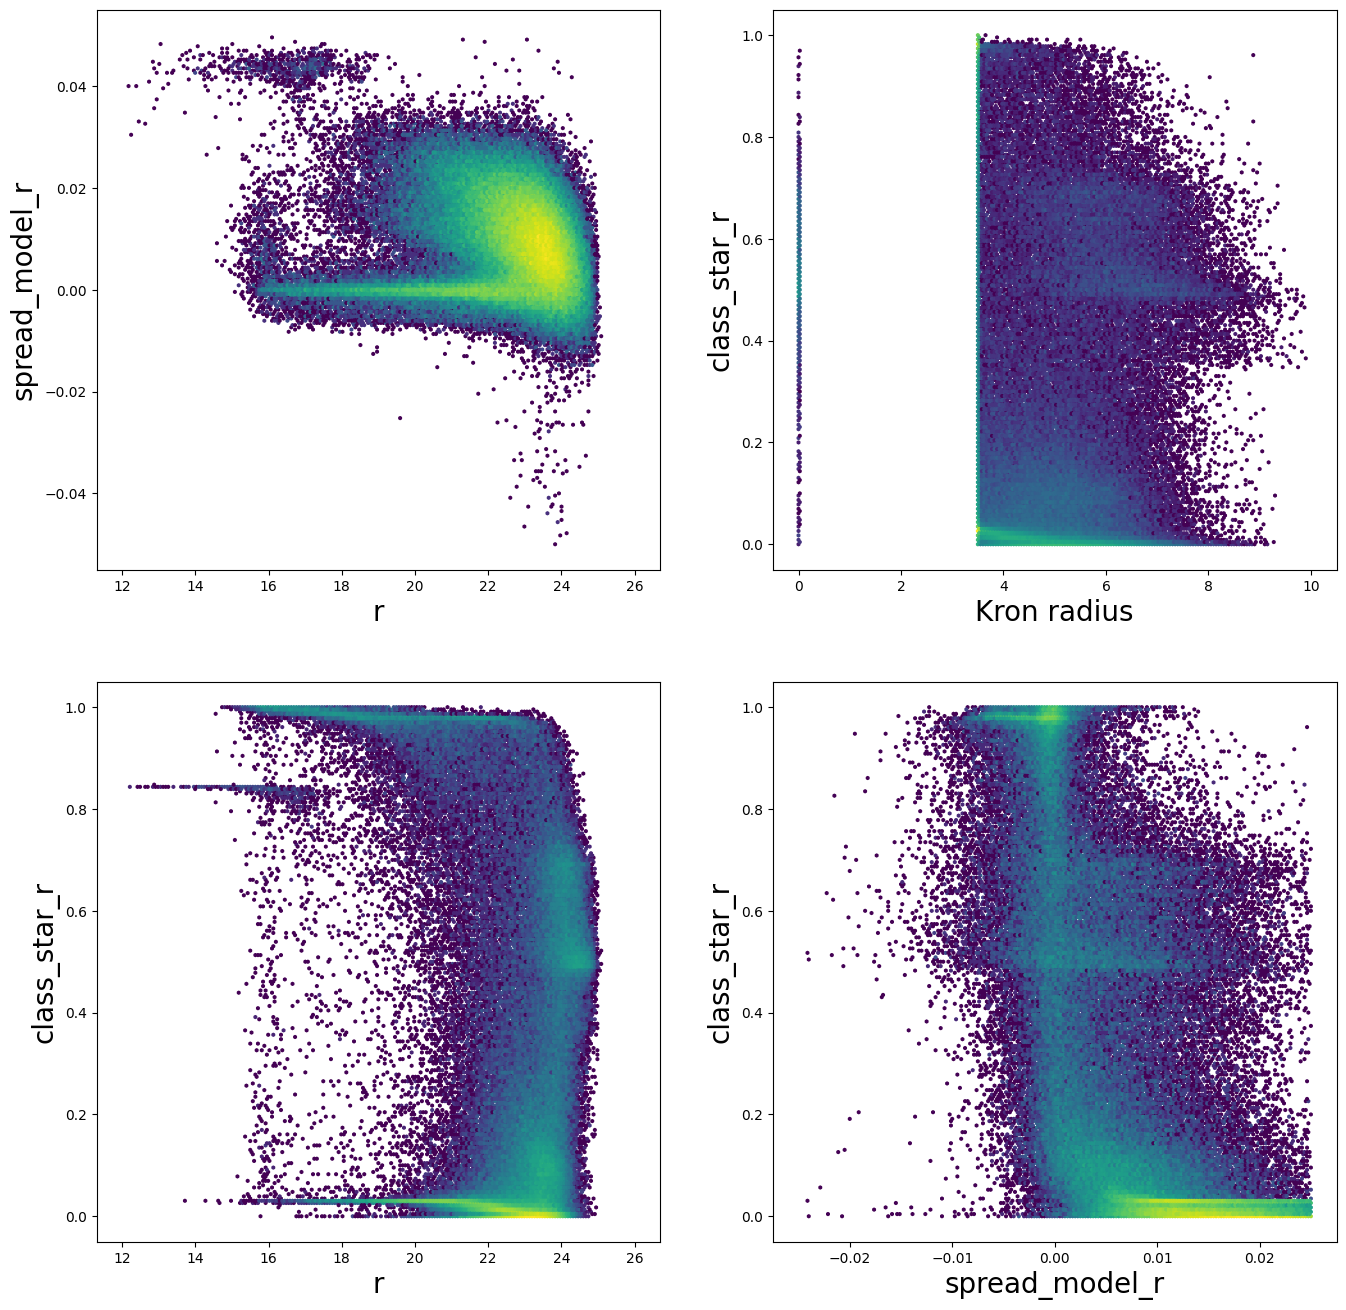

In [10]:
# invalid mags are set to 99 -> mag_auto_X < 90
# spread_model_X is valid at abs(spread_model)<1
# require S/N>5 in the r band
df_in=df[(df['gmag']<90) & (df['imag']<90) & (df['spread_model_r']>(-1)) & \
      (df['rmag']<90) & (df['zmag']<90) & (df['spread_model_r']<1) & \
      ((df['snr_r'])>5)]

print('Number of objects with S/N>5 & valid spread_model in r band: ',len(df_in))

plot_morph(df_in,band='r')

The plots above are very similar to the equivalent in the *g* band except that the ridge-like structures along `class_star` values between 0.3-0.7 are less prominent.

### *z* band

Third, we plot the results only for the *z* band, requiring a signal-to-noise > 5 in the *z* filter.

Number of objects with S/N>5 & valid spread_model in z band:  149652


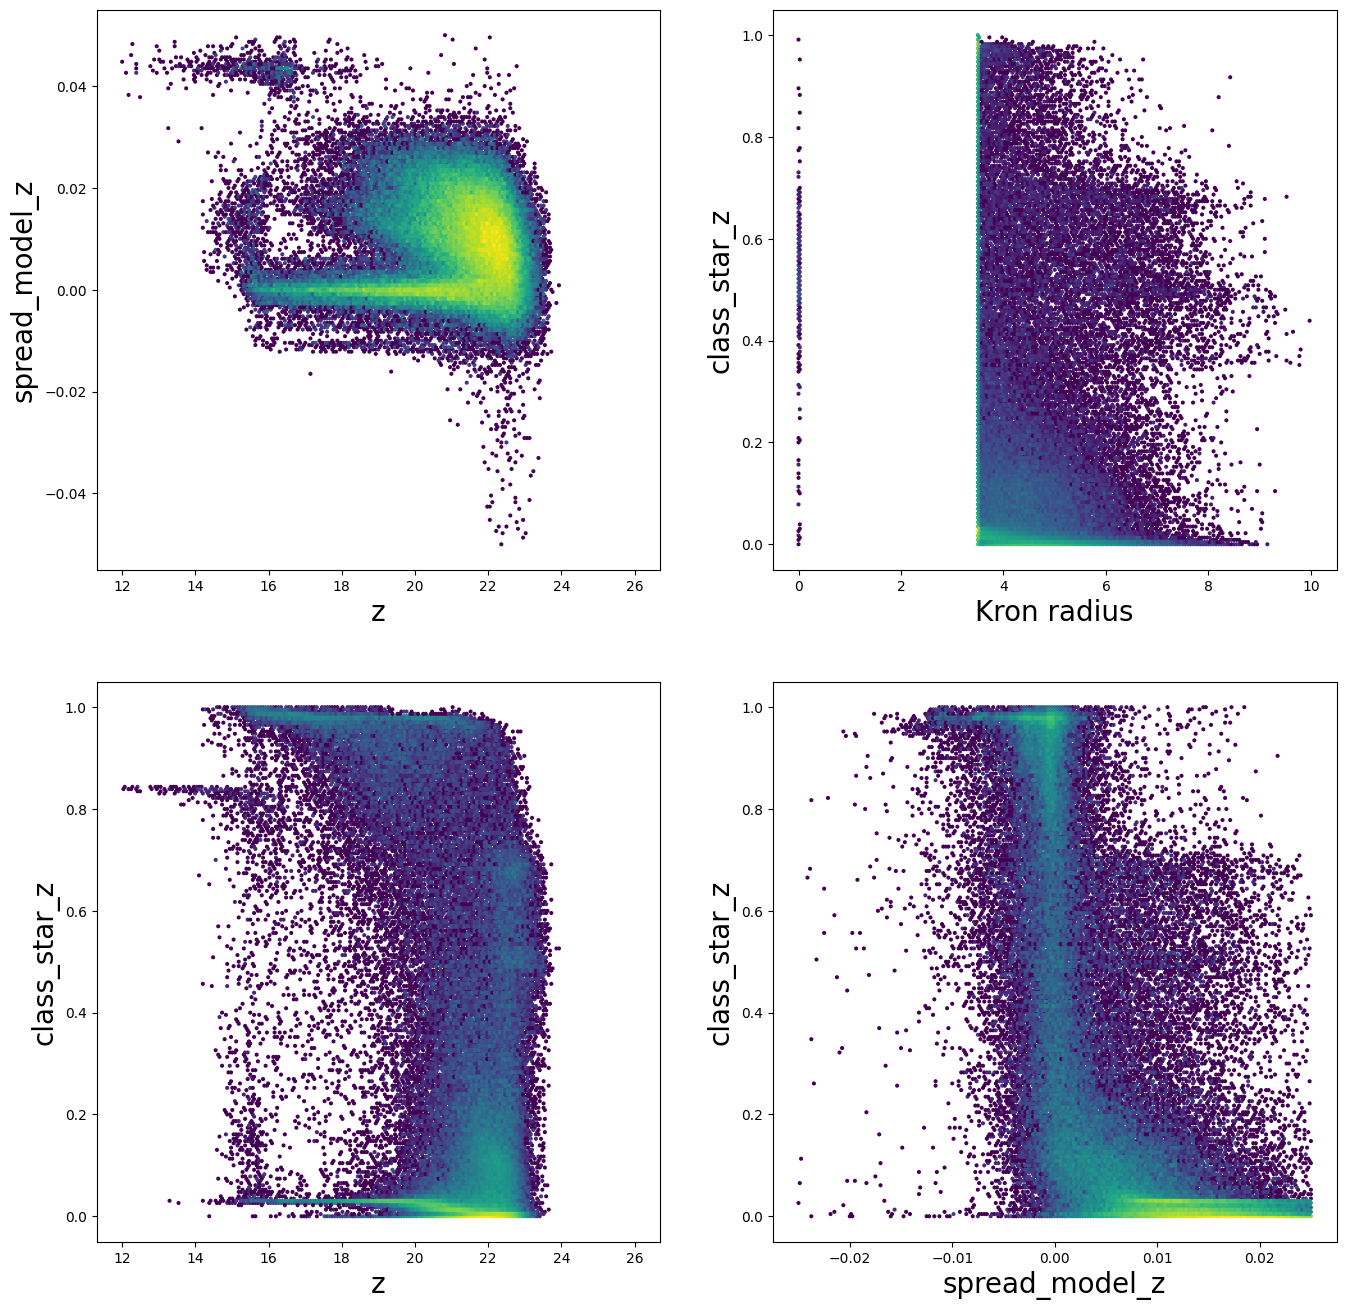

In [11]:
# invalid mags are set to 99 -> mag_auto_X < 90
# spread_model_X is valid at abs(spread_model)<1
# require S/N>5 in the z band
df_in = df[(df['gmag']<90) & (df['imag']<90) & (df['spread_model_z']>(-1)) & \
        (df['rmag']<90) & (df['zmag']<90) & (df['spread_model_z']<1) & \
        ((df['snr_z'])>5)]

print('Number of objects with S/N>5 & valid spread_model in z band: ',len(df_in))

plot_morph(df_in,band='z')

The plots above are very similar to the equivalent in the *g* & *r* band except that the ridge-like structures along `class_star` values between 0.3-0.7 are much less prominent than even in the *r* band. The overlap between `spread_model` values for stars and galaxies also seems less severe than for the *g* and *r* bands.

### Combining bands

Above, the `spread_model` yields the best separation in the *z* band, as well as the fewest ridge features in distribution of `class_star`. On the other hand, the *g* band shows the most overlap in `spread_model` values at faint magnitudes, and the most striking ridges in the distribution of `class_star`. For testing purposes, let's see what happens for cases that have detections in all 3 *g,r,z* bands, and then when the classification agrees between the bands.

Next, we plot again the "worst" case (*g* band) but requiring objects to have S/N>5 in all of *g,r,z* bands.

Number of objects with S/N>5 in g, r, z bands & valid spread_model in g:  106016


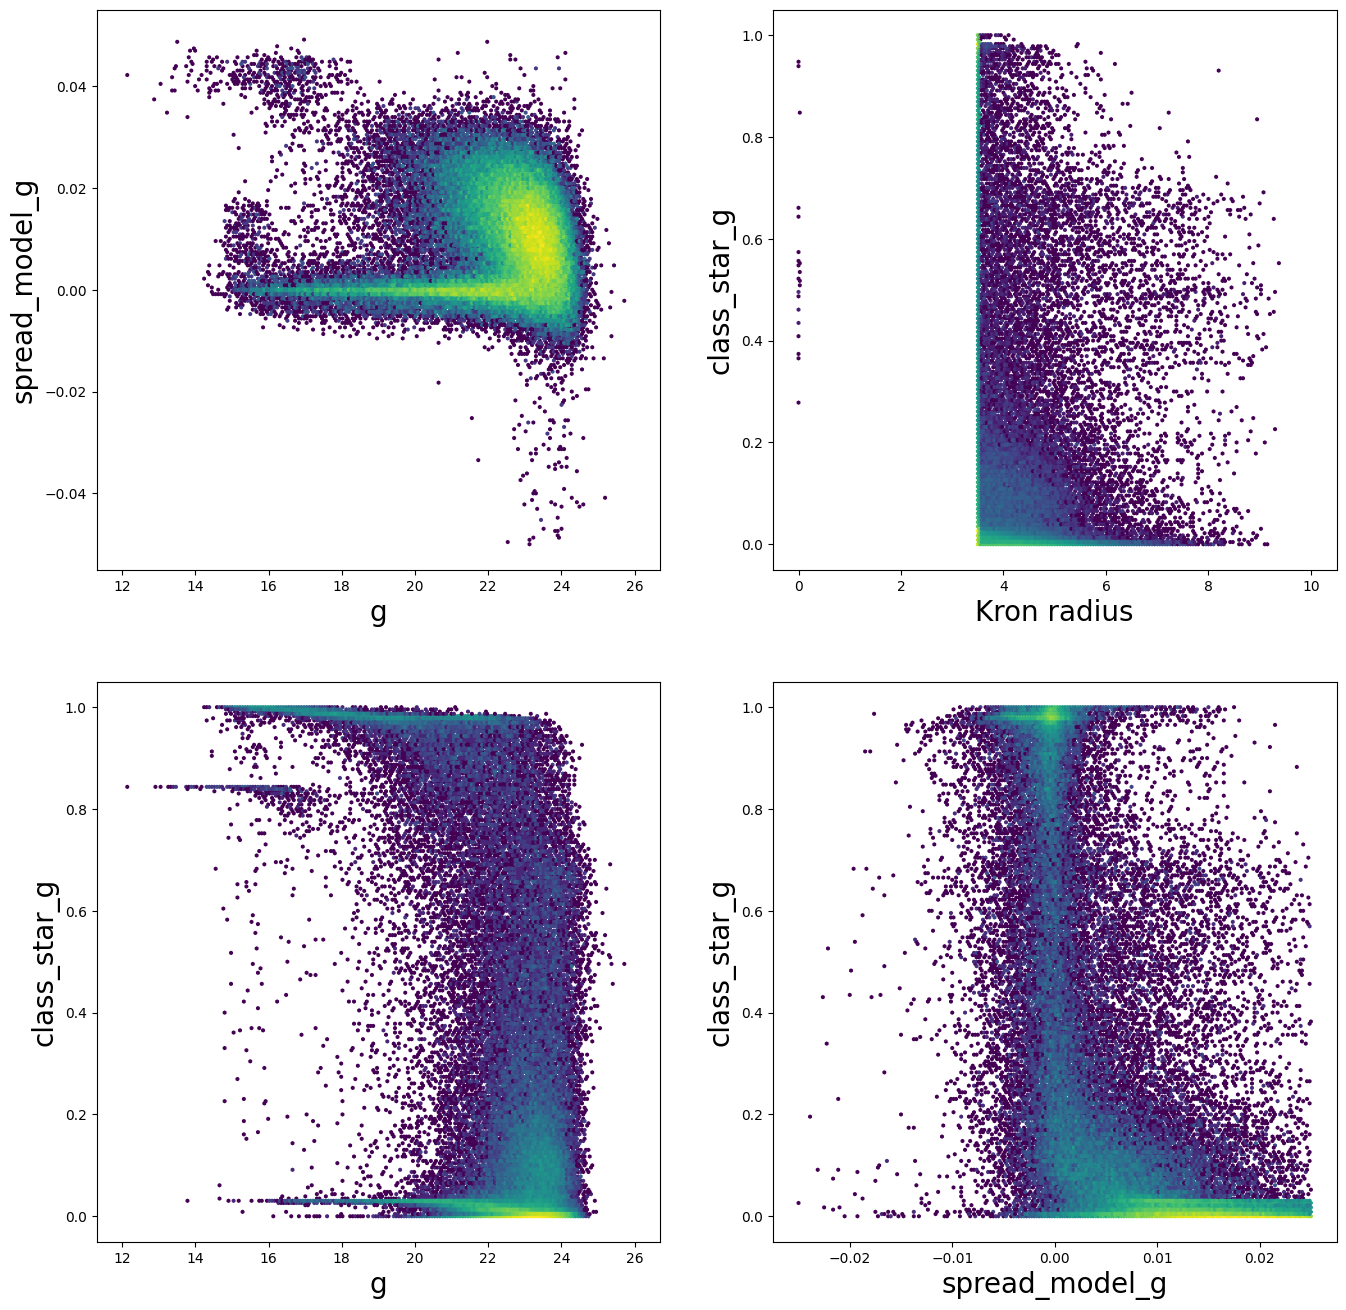

In [12]:
# invalid mags are set to 99 but requiring S/N>5 will only keep valid mags
# spread_model_X is valid at abs(spread_model)<1
# require S/N>5 in the g, r, z band
df_in=df[(df['spread_model_g']>(-1)) & (df['spread_model_g']<1) & \
      (df['snr_g']>5) & (df['snr_r']>5) & (df['snr_z']>5)]

print('Number of objects with S/N>5 in g, r, z bands & valid spread_model in g: ',len(df_in))

plot_morph(df_in,band='g')

The test above resulted in cleaner plots with fewer ridges on the `class_star` parameter.

Now, let's test what happens in cases with agreement or disagreement of the value of `class_star` between bands. We are going to define categories as follows:

* **Galaxies (good)**: `class_star` < 0.5 in all bands 
* **Galaxies (bad)**: `class_star` < 0.5 in *g* but not in *r* or *z*
* **Stars (good)**: `class_star` > 0.5 in all bands 
* **Stars (bad)**: `class_star` > 0.5 in *g* but not in *r* or *z*

The cut at 0.5 is somewhat arbitrary. The primary motivation is to test how the samples behave if they have a consistent classification between all 3 bands, versus a conflicting classification between the *g* band and at least of the other two bands (*r* and/or *z*).

In [13]:
def plot_spread_mag(df_input,i,label=None,**kwargs):
    ax = fig.add_subplot(2,2,i+1)
    ax.hexbin(df_input['gmag'],df_input['spread_model_g'],gridsize=200,bins='log',mincnt=1,extent=(12,26,-0.05,0.05))
    ax.set_xlabel('g',fontsize=20)
    ax.set_ylabel('spread_model_g',fontsize=20)
    ax.tick_params(labelsize=10)
    if label is not None:
        ax.text(0.1,0.1,label,transform=ax.transAxes,fontsize=18,color='red',backgroundcolor='white')

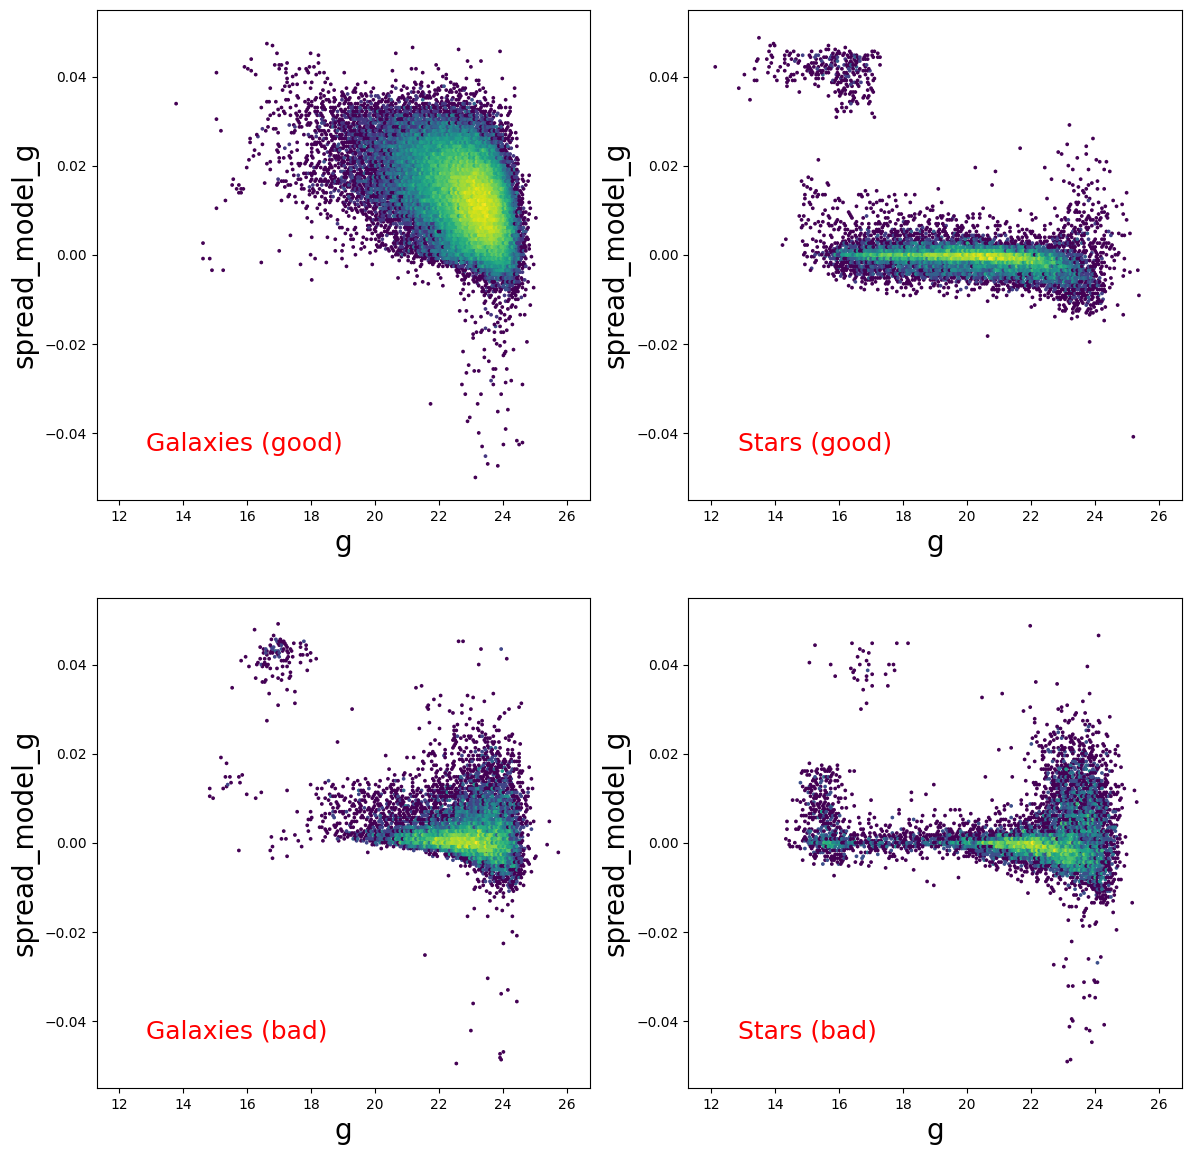

In [14]:
# invalid mags are set to 99 -> mag_auto_X < 90
# spread_model_X is valid at abs(spread_model)<1
# require S/N>5 in the g, r, z band
df=df[(df['spread_model_g']>(-1)) & (df['spread_model_g']<1) & \
      (df['snr_g']>5) & (df['snr_r']>5) & (df['snr_z']>5)]

df_gal    = df[(df['class_star_g']<0.5) & (df['class_star_r']<0.5) & (df['class_star_z']<0.5)]
df_notok  = df[(df['class_star_g']<0.5) & ((df['class_star_r']>0.5) | (df['class_star_z']>0.5))]
df_star   = df[(df['class_star_g']>0.5) & (df['class_star_r']>0.5) & (df['class_star_z']>0.5)]
df_notok2 = df[(df['class_star_g']>0.5) & ((df['class_star_r']<0.5) | (df['class_star_z']<0.5))]

fig = plt.figure(figsize=(7*2,7*2))

plot_spread_mag(df_gal,0,label='Galaxies (good)')
plot_spread_mag(df_star,1,label='Stars (good)')
plot_spread_mag(df_notok,2,label='Galaxies (bad)')
plot_spread_mag(df_notok2,3,label='Stars (bad)')

# Uncomment the following 2 lines to save a PNG file to your local notebook directory
#outfile = 'class_star_g_TESTS.png'
#fig.savefig(outfile, bbox_inches='tight')

As displayed in the top row, objects with consistent classifications between bands show the cleanest separation. The bottom row displays objects with a conflicting classification. The *g*-band galaxies with a conflicting *r* and/or *z* band classification tend to have `spread_model` near 0, as expected for point-like sources, but with a large scatter at faint magnitudes or perhaps joining with an actual population of galaxies. The *g*-band stars with a conflicting *r* and/or *z* band classification behave like a mixture of stars with `spread_model` near 0 and a clear other population contributing at *g*>23.

## Optical color-color diagram with new sample definition

We repeat the color-color plot from the Plot results section, but now split into the categories defined above:

* **Galaxies (good)**: `class_star` < 0.5 in all bands 
* **Galaxies (bad)**: `class_star` < 0.5 in *g* but not in *r* or *z*
* **Stars (good)**: `class_star` > 0.5 in all bands 
* **Stars (bad)**: `class_star` > 0.5 in *g* but not in *r* or *z*

In [15]:
def plot_grz(df_input,i,label=None,**kwargs):
    col0 = df_input['rmag'] - df_input['zmag']   #r-z color
    col1 = df_input['gmag'] - df_input['rmag']   #g-r color
    
    # 2D-histogram of objects
    ax = fig.add_subplot(2,2,i+1)
    ax.hexbin(col0, col1, bins='log', cmap=plt.cm.viridis, gridsize=140, 
               mincnt=1, extent=(-1., 3, -1., 3))
    ax.set_xlabel('r-z',fontsize=20)
    ax.set_ylabel('g-r',fontsize=20)

    if label is not None:
        ax.text(0.1,0.9,label,transform=ax.transAxes,fontsize=16,color='red',backgroundcolor='white')

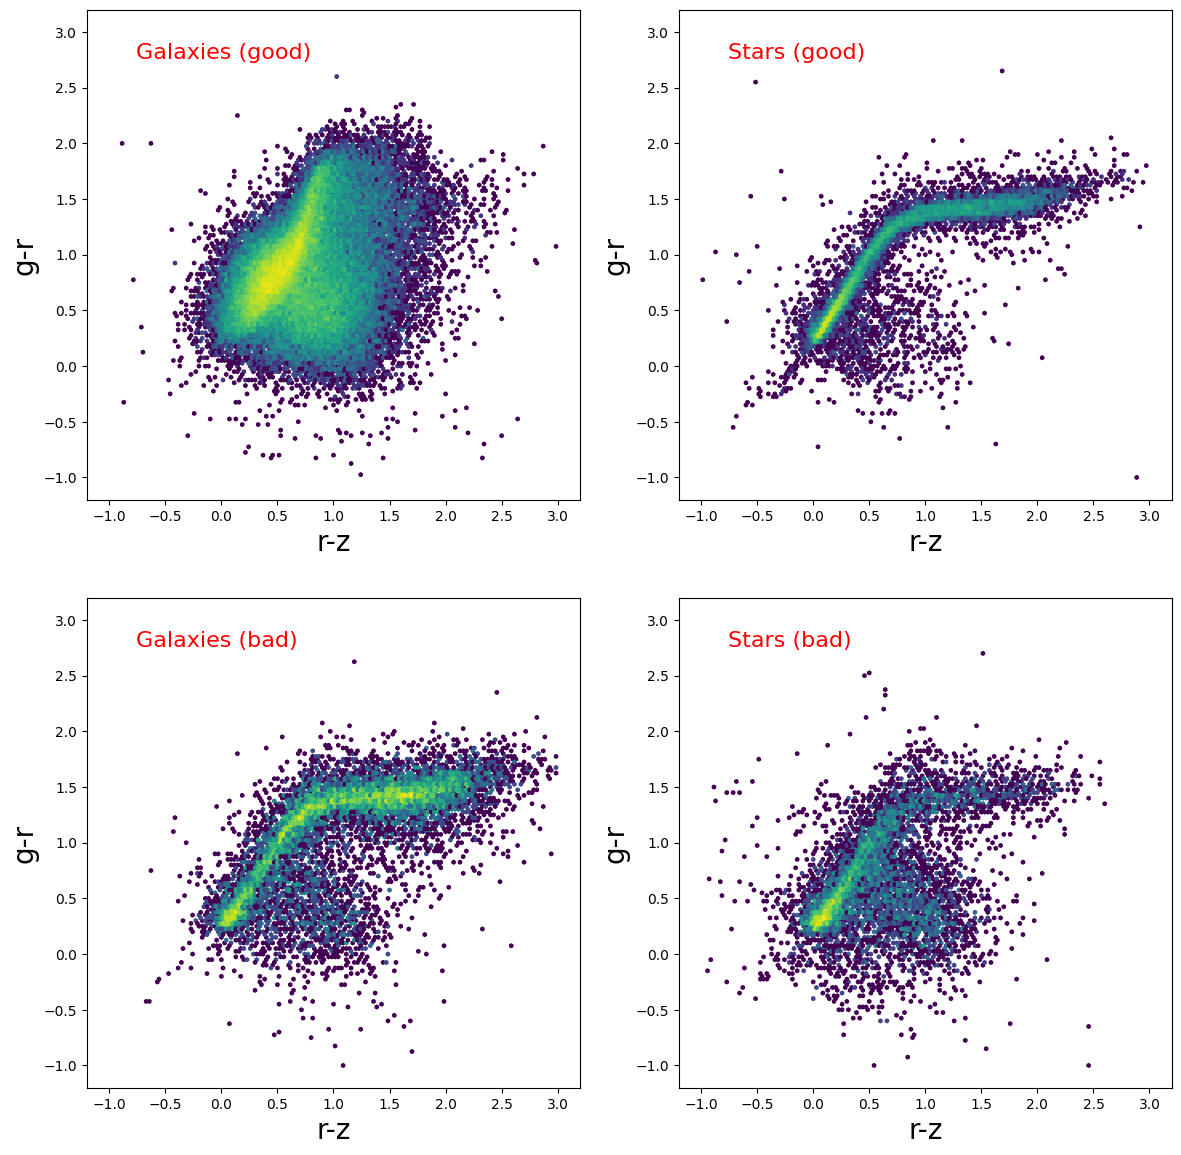

In [16]:
fig = plt.figure(figsize=(7*2,7*2))

plot_grz(df_gal,0,label='Galaxies (good)')
plot_grz(df_star,1,label='Stars (good)')
plot_grz(df_notok,2,label='Galaxies (bad)')
plot_grz(df_notok2,3,label='Stars (bad)')

# Uncomment the following 2 lines to save a PNG file to your local notebook directory
#outfile = 'grz_DESDR1.png'
#fig.savefig(outfile, bbox_inches='tight')

The galaxy branch and the stellar locus on the *g-r* vs. *r-z* plane are much cleaner. However, it is not clear what happens to the QSO's. It could be that they are mostly in the "cloud" below the branches and most obvious in the panel labeled "Stars (bad)". This means that they would look like a star in *g* but not in either *r* or *z*. At a fixed *r-z*, QSOs would be bluer than stars in *g-r*. One could investigate with spectroscopy or templates to confirm.

## Comparison with LS + SDSS

For reference, this is a figure with LS (DECaLS) photometry for SDSS DR13 spectral classification (comparatively bright objects).

<figure>
<img src="ls_sdss_starGalQso.jpg", align="center", width=900>
<figcaption>Figure: Color-color diagrams of DECaLS photometry split by SDSS spectral classes. Slightly modified version of figure by Bela Abolfathi (UC Irvine). </figcaption>
</figure>

## DES DR1 with *g*<22

The color-color plots are repeated for **bright** objects (*g* < 22 mag) and again split into the four categories defined previously. 

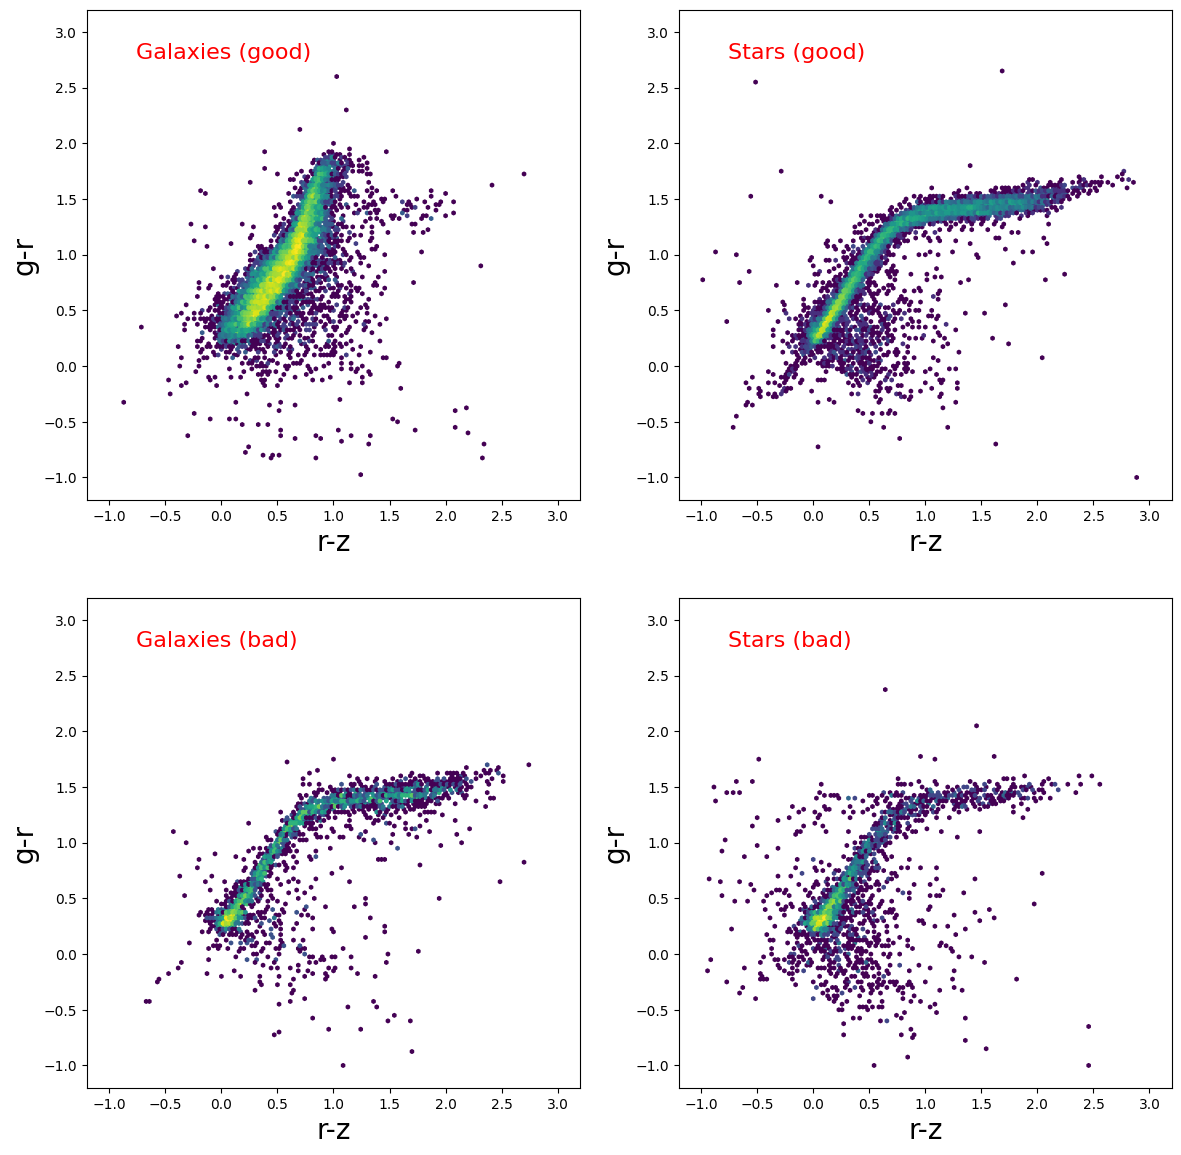

In [17]:
# Repeat above with with gmag < 22 as in SDSS/BOSS DR12Q

g22_gal    = df[(df['class_star_g']<0.5) & (df['class_star_r']<0.5) & (df['class_star_z']<0.5) & (df['gmag']<22.)]
g22_notok  = df[(df['class_star_g']<0.5) & ((df['class_star_r']>0.5) | (df['class_star_z']>0.5)) & (df['gmag']<22.)]
g22_star   = df[(df['class_star_g']>0.5) & (df['class_star_r']>0.5) & (df['class_star_z']>0.5) & (df['gmag']<22.)]
g22_notok2 = df[(df['class_star_g']>0.5) & ((df['class_star_r']<0.5) | (df['class_star_z']<0.5)) & (df['gmag']<22.)]

fig = plt.figure(figsize=(7*2,7*2))

plot_grz(g22_gal,0,label='Galaxies (good)')
plot_grz(g22_star,1,label='Stars (good)')
plot_grz(g22_notok,2,label='Galaxies (bad)')
plot_grz(g22_notok2,3,label='Stars (bad)')

# Uncomment the following 2 lines to save a PNG file to your local notebook directory
#outfile = 'grz_DESDR1_gLT22.png'
#fig.savefig(outfile, bbox_inches='tight')

The galaxies and stars with consistent classifications follow tight branches with limited scatter. Interestingly, the *g*-band galaxies with a conflicting classification (bad) follow the same locus as the good stars. This indicates that the *r* and *z* band classification as star is more appropriate when there is a conflict at *g*<22. Since the *g*-band stars with a conflicting classification also follow the locus of the good stars, a more general statement would be that objects with a conflicting classification at bright magnitude (*g*<22) are likely stars.

## DES DR1 with *g*>23

The color-color plots are repeated for **faint** objects (*g* > 23 mag) and again split into the four categories defined previously. 

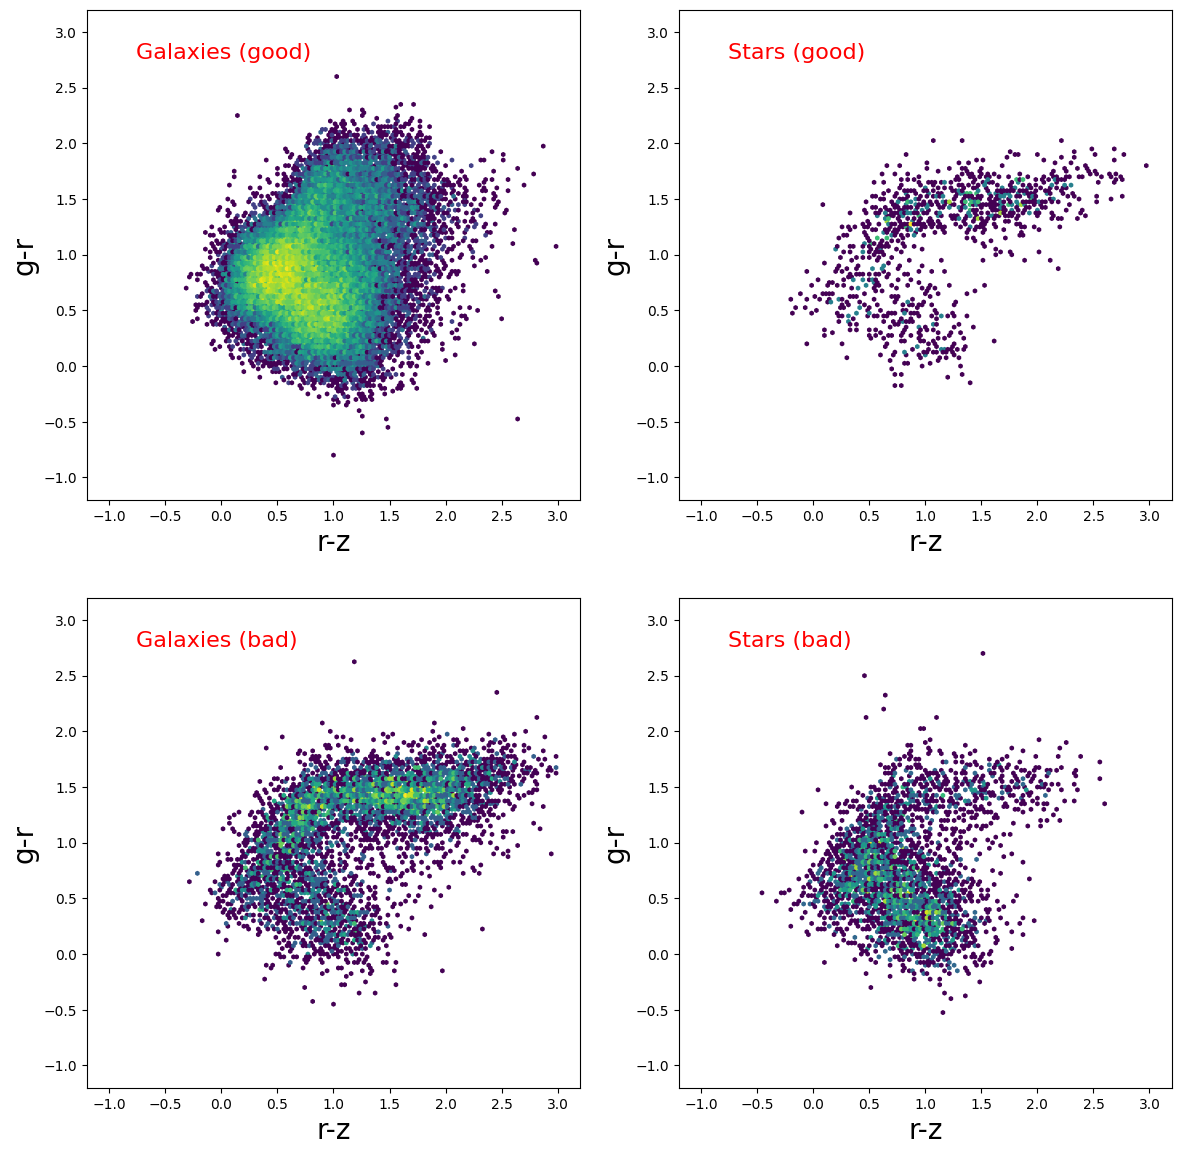

In [18]:
# Repeat above with with gmag > 23 (1 mag fainter than SDSS/BOSS DR12Q)

g23_gal    = df[(df['class_star_g']<0.5) & (df['class_star_r']<0.5) & (df['class_star_z']<0.5) & (df['gmag']>23.)]
g23_notok  = df[(df['class_star_g']<0.5) & ((df['class_star_r']>0.5) | (df['class_star_z']>0.5)) & (df['gmag']>23.)]
g23_star   = df[(df['class_star_g']>0.5) & (df['class_star_r']>0.5) & (df['class_star_z']>0.5) & (df['gmag']>23.)]
g23_notok2 = df[(df['class_star_g']>0.5) & ((df['class_star_r']<0.5) | (df['class_star_z']<0.5)) & (df['gmag']>23.)]

fig = plt.figure(figsize=(7*2,7*2))

plot_grz(g23_gal,0,label='Galaxies (good)')
plot_grz(g23_star,1,label='Stars (good)')
plot_grz(g23_notok,2,label='Galaxies (bad)')
plot_grz(g23_notok2,3,label='Stars (bad)')

# Uncomment the following 2 lines to save a PNG file to your local notebook directory
#outfile = 'grz_DESDR1_gGT23.png'
#fig.savefig(outfile, bbox_inches='tight')

In the plot above, the stellar locus is broad and curved in a way that overlaps with galaxies, and with a very similar shape between good Stars and bad Galaxies. The increased scatter and increased overlap make using these colors for object identification more difficult compared to the situation for bright objects. Further investigation might help to identify the actual nature of the objects shown above. One possibility would be to fold in infrared photometry from WISE.

<a class="anchor" id="compare"></a>
# Appendix: comparison with DES Team classification

This section includes notes on a possible star-galaxy classification from the DES team. Please see the [DES DR1 paper](https://ui.adsabs.harvard.edu/abs/2018ApJS..239...18A) for the latest definition. It could be interesting to make a direct comparison with the categories above.

**des_dr1.main** is the table that would be used at Data Lab.

Stars:

    WHERE
    ( (CASE WHEN spread_model_i + 3. * spreaderr_model_i > 0.005 THEN 1 ELSE 0 END) +
    (CASE WHEN spread_model_i + 1. * spreaderr_model_i > 0.003 THEN 1 ELSE 0 END) +
    (CASE WHEN spread_model_i - 1. * spreaderr_model_i > 0.003 THEN 1 ELSE 0 END) ) <= 1
    AND spread_model_i BETWEEN -0.05 AND 0.05
    AND imaflags_iso_i = 0
    AND flags_i < 4

Galaxies:

    WHERE
    ( (CASE WHEN spread_model_i + 3. * spreaderr_model_i > 0.005 THEN 1 ELSE 0 END) +
    (CASE WHEN spread_model_i + 1. * spreaderr_model_i > 0.003 THEN 1 ELSE 0 END) +
    (CASE WHEN spread_model_i - 1. * spreaderr_model_i > 0.003 THEN 1 ELSE 0 END) ) = 3
    AND spread_model_i BETWEEN -0.05 AND 0.05
    AND imaflags_iso_i = 0
    AND flags_i < 4
    AND mag_auto_i < 23

Please note that if using other bands such as *g* and *r*, one might need to also require:

    imaflags_iso_g = 0
    imaflags_iso_r = 0
    flags_g < 4
    flags_r < 4
    
The exact cuts could be adapted slightly depending on the desired trade-off between purity versus completeness in the sample selection. 

<a class="anchor" id="classstar"></a>
# Appendix: `class_star` comparison

We compare, for the 4 categories defined above, the `class_star` values between *g* and *r* bands, and between *g* and *z* bands. Cases with consistent classifications in all 3 bands should only have points in the corresponding quadrant (<0.5 for galaxies or >0.5 for stars). Given that the inconsistent "bad" classifications means a conflict with the *r* classification **and/or** the *z* classification, the distributions will spread over two quadrants in these cases.

In [19]:
def plot_class_star_gr(df_input,i,label=None,**kwargs):
    ax = fig.add_subplot(2,4,i+1)
    ax.hexbin(df_input['class_star_r'],df_input['class_star_g'],gridsize=200,bins='log',mincnt=1,extent=(0,1,0,1.2))
    ax.set_xlabel('class_star_r',fontsize=10)
    ax.set_ylabel('class_star_g',fontsize=10)
    ax.tick_params(labelsize=10)
    if label is not None:
        ax.text(0.1,0.9,label,transform=ax.transAxes,fontsize=16,color='red',backgroundcolor='white')

In [20]:
def plot_class_star_gz(df_input,i,label=None,**kwargs):
    ax = fig.add_subplot(2,4,i+1)
    ax.hexbin(df_input['class_star_z'],df_input['class_star_g'],gridsize=200,bins='log',mincnt=1,extent=(0,1,0,1.2))
    ax.set_xlabel('class_star_z',fontsize=10)
    ax.set_ylabel('class_star_g',fontsize=10)
    ax.tick_params(labelsize=10)
    if label is not None:
        ax.text(0.1,0.9,label,transform=ax.transAxes,fontsize=16,color='red',backgroundcolor='white')

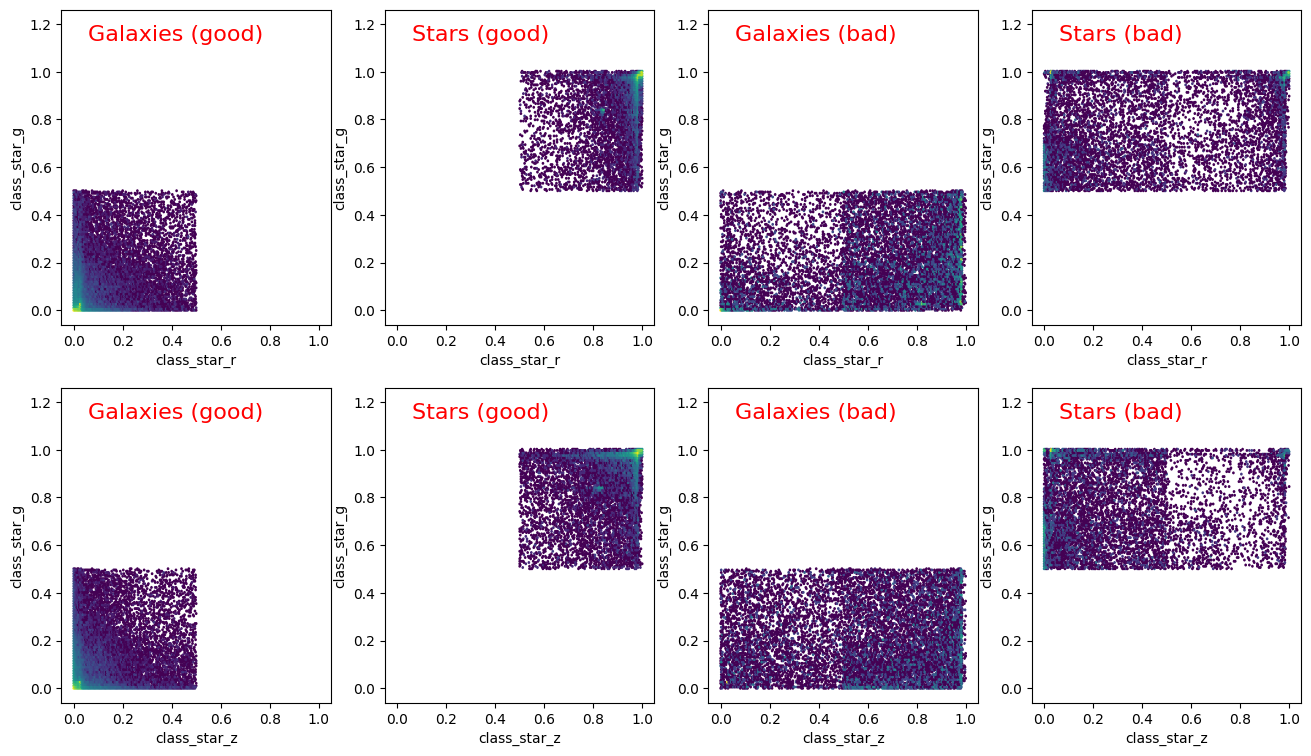

In [21]:
fig = plt.figure(figsize=(4*4,4.5*2))

plot_class_star_gr(df_gal,0,label='Galaxies (good)')
plot_class_star_gr(df_star,1,label='Stars (good)')
plot_class_star_gr(df_notok,2,label='Galaxies (bad)')
plot_class_star_gr(df_notok2,3,label='Stars (bad)')

plot_class_star_gz(df_gal,4,label='Galaxies (good)')
plot_class_star_gz(df_star,5,label='Stars (good)')
plot_class_star_gz(df_notok,6,label='Galaxies (bad)')
plot_class_star_gz(df_notok2,7,label='Stars (bad)')

# Uncomment the following 2 lines to save a PNG file to your local notebook directory
#outfile = 'class_star_g_COMPARE.png'
#fig.savefig(outfile, bbox_inches='tight')

<a class="anchor" id="resources"></a>
# References

[DES Collaboration (2018)](https://ui.adsabs.harvard.edu/abs/2018ApJS..239...18A)

[Soumagnac et al (2015)](http://adsabs.harvard.edu/abs/2015MNRAS.450..666S)

[Desai et al (2012)](http://adsabs.harvard.edu/abs/2012ApJ...757...83D)
